# Final Project Code

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid, cumulative_trapezoid, odeint
import rootfinder as rtf

In [3]:
class QM(object):
    def __init__(self, Potential, E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01):
        self.Potential = Potential
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
    
        """right hand side of the differential equation"""
        u = uv[1]
        v = 2*(self.Potential(x) - self.E)*uv[0]
        return np.ravel(np.array([u, v]))

In [76]:
N = 10001
bounds = 10.0

def hartree_solve(charge, outer, E):
    dr = bounds/(N-1)
    Potential = lambda r: Qscale*((-Z + np.interp(r, r_points, charge))/r + np.interp(r, r_points, outer))
    electron = QM(Potential, E, N, bounds, 0.0, 0.0, -0.01)
    electron.scipy_trajectory()
    return electron.uv

def shoot(charge, outer, n):
    dE = 0.3
    target = lambda E: hartree_solve(charge, outer, E)[-1,0]
    Elow = -10.0
    Esol = None
    while True:
        Esol = rtf.bisect(target, Elow, Elow+dE)
        if (Esol):
            if (n):
                n -= 1
            else:
                break
        Elow += dE
    return Esol

Energies (eV): [0. 0. 0.]


/opt/conda/envs/phys1600/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-104-f9c57d4c7c8b>:36: RuntimeWarning: divide by zero encountered in true_divide
  outer = (u**2/A)/r_points


Energies (eV): [-219.07749293 -219.07749293  -54.76936743]
Energies (eV): [-129.66694647 -129.66694647  -16.76614447]
Energies (eV): [-141.49621702 -141.49621702  -17.1088004 ]
Energies (eV): [-140.67957771 -140.67957771  -17.04936088]
Energies (eV): [-140.78158021 -140.78158021  -17.05589474]
Energies (eV): [-140.7705253  -140.7705253   -17.05518251]
Energies (eV): [-140.77171749 -140.77171749  -17.05525993]
Energies (eV): [-140.77157814 -140.77157814  -17.05525993]
Energies (eV): [-140.77159363 -140.77159363  -17.05525993]
Total Energy: -389.78945064708404 eV


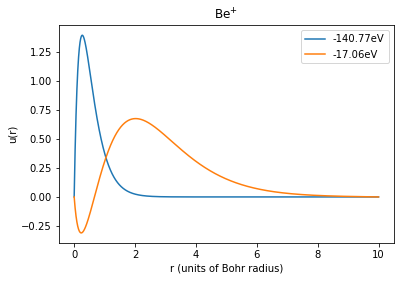

In [104]:
Z = 4
Ne = 3 # Number of electrons
a0 = 5.29e-11
hbar = 1.05e-34
m_e = 9.1e-31
e = 1.6e-19
Escale = hbar**2/(e*m_e*a0**2)
Qscale = e/a0 * 9e9 / Escale

r_points = np.linspace(0.0, bounds, N, endpoint=True)
E1 = [0]*Ne
E0 = [None]*Ne
u = np.zeros((Ne, N))
cumprob = np.zeros((Ne, N))
outer_potential = np.zeros((Ne, N))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Be$^{+}$')
ax.set_xlabel('r (units of Bohr radius)')
ax.set_ylabel('u(r)')

while True:
    print('Energies (eV):', np.array(E1)*Escale)
    for i in range(Ne):
        E0[i] = E1[i]
        charge = np.sum(cumprob[:i], axis=0) + np.sum(cumprob[i+1:], axis=0) # cumulative charge upto r due to other electrons
        outer = np.sum(outer_potential[:i], axis=0) + np.sum(outer_potential[i+1:], axis=0) # potential due to charge beyond r
        E1[i] = shoot(charge, outer, i//2)
        u[i] = hartree_solve(charge, outer, E1[i])[::-1,0]
        if (abs(E1[i]-E0[i]) < 1e-7):
            E0[i] = E1[i]
    
    cumprob = cumulative_trapezoid(u**2, r_points, initial=0.0)
    A = cumprob[:,-1].reshape((Ne,1))
    outer = (u**2/A)/r_points
    outer[:,0] = 0
    outer_potential[:,::-1] = cumulative_trapezoid(outer[:,::-1], r_points, initial=0.0)
    if (E1 == E0):
        u = u/np.sqrt(A)
        break
        
    cumprob /= A

Etotal = 0
for i in range(Ne):
    outer = np.sum(outer_potential[:i], axis=0) + np.sum(outer_potential[i+1:], axis=0)
    Edouble = trapezoid(Qscale*u[i]**2*outer, r_points) # Remove double-counted energy
    if i % 2 == 0:
        ax.plot(r_points, u[i], label=str(round(E1[i]*Escale*100)/100) + 'eV')
    Etotal += (E1[i]-Edouble)*Escale
ax.legend()
print('Total Energy:', Etotal, 'eV')